In [28]:
import pandas as pd
import sklearn

In [29]:
df = pd.read_table('https://raw.githubusercontent.com/sinanuozdemir/sfdat22/master/data/sms.tsv', sep='\t', header=None, names=['label', 'msg'])
df.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


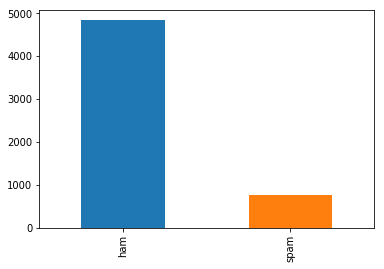

In [30]:
df.label.value_counts().plot(kind="bar")

In [12]:
df.label.value_counts() / df.shape[0] # 비율을 검사

ham     0.865937
spam    0.134063
Name: label, dtype: float64

![](https://ws4.sinaimg.cn/large/006tNbRwgy1fyany5gzszj30bg03fglk.jpg)

P(H) : 이것은 사전 확률, 데이터를 보기 전에 데이터 포인트가 P(H)가 속할 확률
P(D) : 이것은 정규화 상수다.

이제 베이지안 분류 이론으 활용해 Spam을 계산해보자.

In [13]:
df.msg = df.msg.apply(lambda x:x.lower())
# 더 쉽게 검색 할 수 있게 모든 문자열을 소문자로
df[df.msg.str.contains('send cash now')].shape

(0, 2)

In [14]:
df[df.msg.str.contains('send cash now')]

,label,msg


아무것도 없다는 뜻.
대신 베이즈 정리에서 나이브 가정(naive assumption)을 할 수 있다. 특징(단어)이 조건적으로 독립적이면 수식을 다시 쓸 수 있다.

P(sand cash now|spam) = P(sand|spam) * P(cash|spam) * P(now|spam)

In [15]:
spams = df[df.label=='spam']
for word in ['send', 'cash', 'now']:
    print(word, spams[spams.msg.str.contains(word)].shape[0] / float(spams.shape[0])) 

send 0.0963855421686747
cash 0.09103078982597054
now 0.2797858099062918


이것으로 다음을 계산할 수 있음
P(send cash now|spam)* P(spam) = (0.096 * 0.091 * 0.280)*.134 = 0.00032

ham에 대해서도 같은 프로시저를 반복하면

P(send cash now|ham)* P(spam) = (0.03 * .003 * .109) * .865 = 0.0000084

이렇게 나오면 send cash now 라는 문장은  0.00032 0.0000084 약 38배 높기 때문에 스팸이라고 말할 수 있다.

---

이 모든 계산을 직접하지 말고, 파이썬의 나이브 베이지 분류자를 활용해 구현 해보기


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
# 간단한 예제로 시작.
train_simple=['call you tonight', 'Call me a cab', 'please call me... PLEASE 44!','send cash now']

# 훈련 데이터의 '어휘'를 학습
vect = CountVectorizer()
train_simple_dtm = vect.fit_transform(train_simple)
pd.DataFrame(train_simple_dtm.toarray(), columns=vect.get_feature_names())

,44,cab,call,cash,me,now,please,send,tonight,you
0,0,0,1,0,0,0,0,0,1,1
1,0,1,1,0,1,0,0,0,0,0
2,1,0,1,0,1,0,2,0,0,0
3,0,0,0,1,0,1,0,1,0,0


In [35]:
# 검정 데이터를 문서 용어 행렬로 변환(기존 어휘 사용)
# test_simple=["please don't call me"]
test_simple=["send cash now"]
test_simple_dtm = vect.transform(test_simple)
test_simple_dtm.toarray()
pd.DataFrame(test_simple_dtm.toarray(), columns=vect.get_feature_names())

,44,cab,call,cash,me,now,please,send,tonight,you
0,0,0,0,1,0,1,0,1,0,0


In [57]:
# 훈련 셋과 검정셋으로 분할
from sklearn.model_selection import train_test_split

# print(df.msg.head())
# print(df.label.head())
X_train, X_test, y_train, y_test = train_test_split(df.msg, df.label, random_state=1)

# vectorizer를 인스턴스화
vect = CountVectorizer()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# 단일 단계로 어휘를 학습하고 문서 용어 행렬을 만든다.
train_dtm = vect.fit_transform(X_train)
train_dtm

(4179,)
(4179,)
(1393,)
(1393,)


<4179x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

요렇게 되면 55209개의 저장된 요소를 압축된 회소 행 형식(compressed sparse row format)으로 저장 sparse matrix

In [37]:
# 검정 데이터를 문서 용어 행렬로 변환
test_dtm = vect.transform(X_test)
test_dtm

<1393x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

열 수를 보면 7456개가 있는 이 것의 의미는 7456개의 단어가 존재한다는 의미이다.

In [38]:
## 나이브 베이즈 모델 구축

# train_dtm을 사용해서 나이브 베이즈 모델을 훈련
from sklearn.naive_bayes import MultinomialNB
# 모델을 불러온다.
nb = MultinomialNB()
# 모델을 인스턴스화
nb.fit(train_dtm,y_train)
# 훈련셋 맞춤

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

이제 변수 nb는 적합한 모델을 유지하며, 모델의 훈련 단계는 우도 함수(likelihood function)을 계산하는 것을 포함하는데, 이것은 각 클래스에 주어진 각 특징의 조건부 확률이다.

우도 함수란?
http://www.ktword.co.kr/abbr_view.php?m_temp1=3214

- 나타난 결과에 따라 여러 가능한 가설들을 평가할 수 있는 측도(Measure)임
        . 확률적으로 조건부확률로 표현할 수 있음 => 2.번항 참조
- 우도는, 확률로 표현되나 각 가설에 대한 가능도/지지도 등의 의미가 강함
        . 여기서, 각 가설에 대한 우도는 그 가설을 지지하는 정도라고 볼 수 있음

In [39]:
preds = nb.predict(test_dtm)

In [40]:
preds

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype='<U4')

모델의 훈련 단계는 우도 함수(likelihood function)를 계산하는 것을 포함하는데, 이것은 각 클래스에 주어진 각 특징의 조건부 확률이다.

모델의 예측 단계는 관찰된 특징이 주어지면 각 클래스의 사후 확률을 계산하고 가장 높은 확률을 갖는 클래스를 선택하는 것을 포함한다. sklearn의 내장된 정확도와 오차 행렬을 사용해 나이브 베이지 모델이 얼마나 잘 작동하는지 살펴본다.

In [41]:
# 예측을 실제 라벨과 비교한다.
from sklearn import metrics


In [42]:
print(metrics.accuracy_score(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))

0.9885139985642498
[[1203    5]
 [  11  174]]


정확도가 99%

이제 오차 행렬을 보면 이전에는 각 행이 실제 값을 나타내는 반면, 열은 예측된 값을 나타내기 때문에 상단 왼쪽 값인 1,203이 참된 부정을 나타낸다. 그런데 부정적이고 긍정적인 것은 무엇인가? 모델에 긍정과 부정이 아닌 spam과 ham문자열을 클래스로 제공했다.
다음을 사용할 수 있다.

In [58]:
nb.classes_

array(['ham', 'spam'], dtype='<U4')

[HAM, SPAM] 1203은 데이터 중 HAM을 HAM이라 맞춘 경우, 5는 SPAM이라 예측했지만, 실제로 HAM이 경우 / 11은 HAM이라 예측했지만, 실제로는 SPAM이였고, 174는 SPAM이라 예측했는데, 진짜 SPAM이라고 맞춘 경우이다. 